# Mask out non-cluster members

In [2]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
import h5py

cutouts = h5py.File('../cutouts_550.hdf')
zs = ascii.read('../../data/processed/camira_final.tbl')['z_cl']
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

In [3]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [4]:
from photutils.background import Background2D
from scipy.interpolate import CloughTocher2DInterpolator

def background_estimate(cutout, mask=None, z=None, cosmo=None):
    """
    Returns an estimate of the 2D background of `cutout`. The background is 
    measured in boxes of size 50px around the edges of the image, and the
    background is interpolated over the entire image. 
    """
    box_size = cutout.shape[0] // 14
    
    # Run photutil's Background2D for the low resolution grid
    bkg_initial = Background2D(cutout, box_size=box_size, mask=mask)
    mesh = bkg_initial.background_mesh

    if cosmo is not None and z is None:
        return bkg_initial.background

    # Extract the edges of the mesh
    Y, X = np.ogrid[:mesh.shape[0], :mesh.shape[1]]
    y_cen, x_cen = (mesh.shape[0] // 2, mesh.shape[1] // 2) 

    box_cen = (box_size - 1) / 2.0

    if cosmo is not None:
        # Create a mask to cover the internal 350 kpc
        px_dist = cosmo.arcsec_per_kpc_proper(z) * 350 * 1/0.168
        size = int(np.ceil(px_dist.value / box_size))
        box = (X > x_cen - size) & (X < x_cen + size) & (Y > y_cen - size) & (Y < y_cen + size)
    else:
        # Get values from the edges of the cutout (basically for backwards compatibility with the old version)
        box = ~((X == 0) | (X == X.shape[1] - 1) | (Y == 0) | (Y == Y.shape[0] - 1))

    # Get values from the mesh corresponding to these coordinates
    vals = mesh[~box]

    # Array of coordinates in image units
    real_square = np.argwhere(~box) * box_size + box_cen

    # Interpolate over the centre of the square
    interp = CloughTocher2DInterpolator(real_square, vals)
    x = np.arange(np.min(real_square[:,0]), np.max(real_square[:,0]))
    y = np.arange(np.min(real_square[:,1]), np.max(real_square[:,1]))
    x, y = np.meshgrid(x, y) # 2D grid
    z = interp(x, y).T

    # Expand the image to the correct size
    edge_widths = (
        (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
        int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
        (int(np.abs(cutout.shape[1] - z.shape[1])/2),
        int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
    )
    bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

    # Return background estimation
    return bkg

def create_circular_mask(z, img, cosmo, radius_kpc=130):
    """
    Returns a circular mask of 130kpc radius for given `z` and given cosmology
    `cosmo` for image `img`.
    """
    # Calculate the radius in pixels
    arcsec_to_px = 1/0.168
    radius = (cosmo.arcsec_per_kpc_proper(z) * radius_kpc).value * arcsec_to_px
    
    # Generate the mask
    centre = (img.shape[1] // 2, img.shape[0] // 2)
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)

    mask = dist_from_centre <= radius

    return mask

def counts2sb(counts, z):
    return 2.5 * np.log10(63095734448.0194 / counts) + 5 * np.log10(0.168) - 10 * np.log10(1+z)

def sb2counts(sb): # without reaccounting for dimming
    return 10**(-0.4*(sb - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

## Try masking out sources that have surface brightness > than the BCG
Not sure whether this will actually be useful, but I think that a few of the lowest ICL fractions end up there because of foreground galaxies contributing when they should be excluded.

/var/folders/f8/xskfv1jd2vndcb2pskfgrvch0000gp/T/ipykernel_1130/2684768698.py:78: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10(63095734448.0194 / counts) + 5 * np.log10(0.168) - 10 * np.log10(1+z)


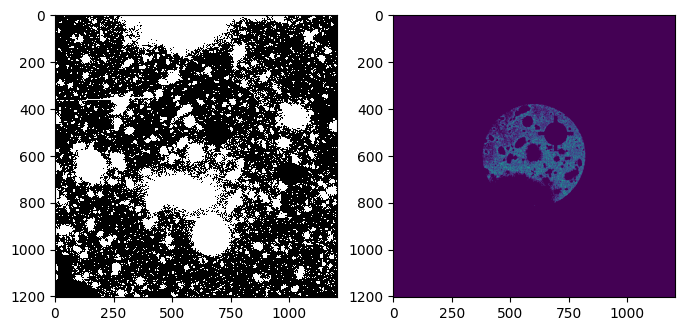

In [5]:
from skimage.segmentation import watershed

# Threshold the image with 25 (26?) mag threshold
cutout_idx = 33
cutout = np.array(cutouts[str(cutout_idx)]['HDU0']['DATA'])
bad_mask = (np.array(cutouts[str(cutout_idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[cutout_idx], cosmo=cosmo)
img = cutout - bkg

sb_img = counts2sb(img, 0)
threshold = 26 + 10 * np.log10(1 + zs[cutout_idx])
mask = sb_img > threshold

circ_mask = create_circular_mask(zs[cutout_idx], cutout, cosmo, radius_kpc=200)

obj_mask = ~(mask + bad_mask + np.isnan(sb_img))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(obj_mask, cmap='gray', interpolation='none')
plt.subplot(122)
plt.imshow(stretch(img) * ~bad_mask * mask * circ_mask) 
plt.show()

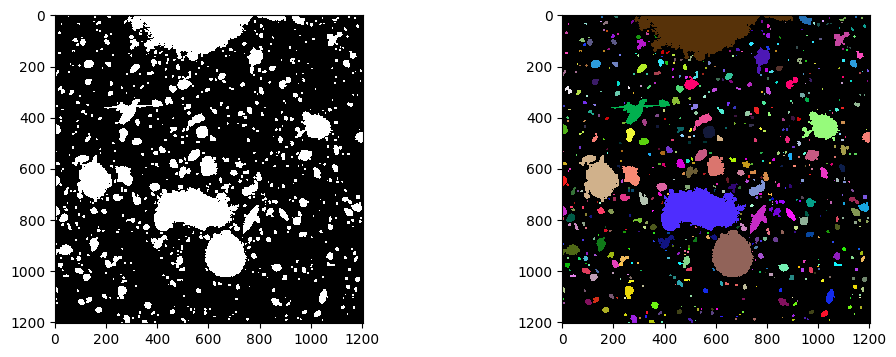

In [6]:
from skimage.morphology import binary_opening
from matplotlib.colors import ListedColormap
import cv2

# Erode and dilate the mask to get rid of the specks
obj_mask_open = binary_opening(obj_mask, np.ones((5,5)))
binary_img = np.array(obj_mask_open, dtype=np.uint8)

# Segment the image using connected components method
_, labels = cv2.connectedComponents(binary_img, connectivity=8)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(obj_mask_open, cmap='gray', interpolation='none')
plt.subplot(122)
colours = np.random.rand(256, 3)
colours[0] = [0,0,0]
cmap = ListedColormap(colours)
plt.imshow(labels, cmap=cmap, interpolation='none')
plt.show()

# Oversegmenting the large galaxy but that might be okay

In [7]:
# Measure the surface brightness of areas corresponding to each label
mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
bcg_label = labels[mid]
bcg_mask = (labels == bcg_label)
bcg_sb = 2.5 * np.log10(63095734448.0194 * 0.168 ** 2 * np.sum(bcg_mask) / (np.sum(cutout * bcg_mask)))

num_labels = np.max(labels)
brighter_obj = []
for label in np.unique(labels):
    mask = (labels == label)
    sb = 2.5 * np.log10(63095734448.0194 * 0.168 ** 2 * np.sum(mask) / (np.sum(cutout * mask)))
    if sb < bcg_sb:
        print(sb)
        brighter_obj.append(label)

22.753621841232224
23.000350337780272
23.369978544039096


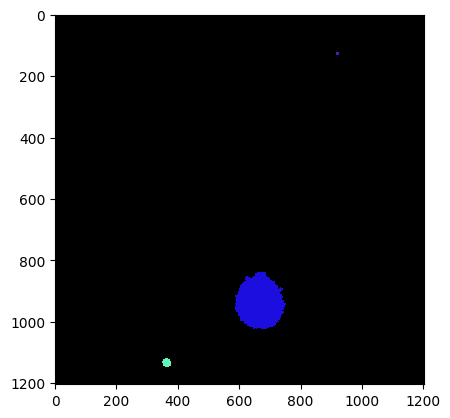

In [8]:
cmap = ListedColormap(colours)
plt.imshow(labels * np.isin(labels, brighter_obj), cmap=cmap, interpolation='none')
plt.show()

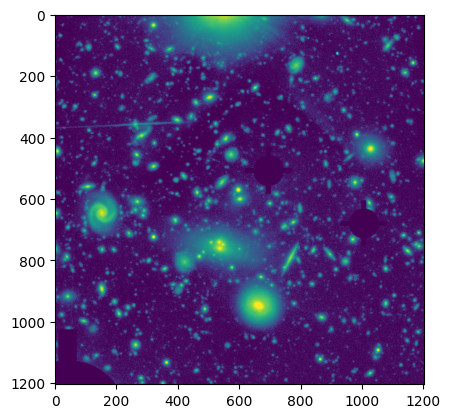

In [9]:
plt.imshow(stretch(img) * ~bad_mask)
plt.show()

Better to use magnitude rather than surface brightness, but might be better to try to get a catalogue of member galaxies.

## Use member galaxy catalogue for masking

In [10]:
from astropy.table import join

# Load the cluster member catalogue
members = ascii.read('../../data/raw/camira_s20a_dud_member.dat', 
                     names=['RA_cl', 'Dec_cl', 'Richness', 'z_cl', 'RA', 'Dec', 'M', 'w'])

# Match this catalogue to the cluster catalogue
clusters = ascii.read('../../data/processed/camira_final.tbl')
merged = join(members, clusters, keys_left=['RA_cl', 'Dec_cl'], keys_right=['RA [deg]', 'Dec [deg]'])
merged = merged['ID', 'Name', 'RA_cl', 'Dec_cl', 'z_cl_1', 'RA', 'Dec']
merged

<Table length=6575>
  ID         Name         RA_cl      Dec_cl   z_cl_1     RA        Dec   
int64       str17        float64    float64  float64  float64    float64 
----- ----------------- ---------- --------- ------- ---------- ---------
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.907027  -4.66417
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.873273 -4.691256
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.928945 -4.684164
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.876194 -4.664761
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.904107 -4.679378
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.934757 -4.684694
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.880616 -4.669356
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.859355 -4.677844
    0 HSCJ021528-044041  33.867663 -4.678112   0.332   33.94297 -4.695663
    0 HSCJ021528-044041  33.867663 -4.678112   0.332  33.864138 -4.674826
  ...               ...        ...       ...     ...        ...       ...
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.905278  0.245359
  124 HSCJ233534+001428 353.893629  0.241214   0.472  353.89281  0.246362
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.900678  0.228819
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.898396  0.253207
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.899637  0.247687
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.868137  0.225652
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.851071  0.214373
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.878795   0.26049
  124 HSCJ233534+001428 353.893629  0.241214   0.472 353.908142  0.247897
  124 HSCJ233534+001428 353.893629  0.241214   0.472  353.86774  0.241989

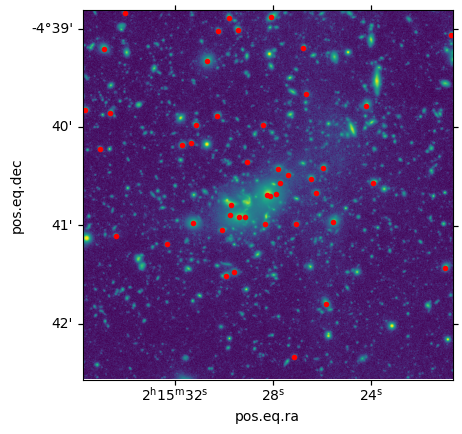

In [11]:
# First plot with fits files so we know that the ra and dec stuff is correct
import glob
from astropy.io import fits
from astropy.wcs import WCS
import re
# Functions to enable sorting in "natural order" (i.e. same order as is in the catalogue). Code from https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

files = glob.glob('../cutouts_550kpc/*fits')
files = sorted(files, key=natural_keys)

idx = 0

hdu = fits.open(files[idx])[1]
wcs = WCS(hdu.header)

ax = plt.subplot(projection=wcs)
ax.imshow(stretch(hdu.data))

c_members = merged[merged['ID'] == idx]

ax.scatter(c_members['RA'], c_members['Dec'], color='red', marker='.', transform=ax.get_transform('world'))
ax.set_xlim((0, hdu.data.shape[0]))
ax.set_ylim((0, hdu.data.shape[1]))

plt.show()

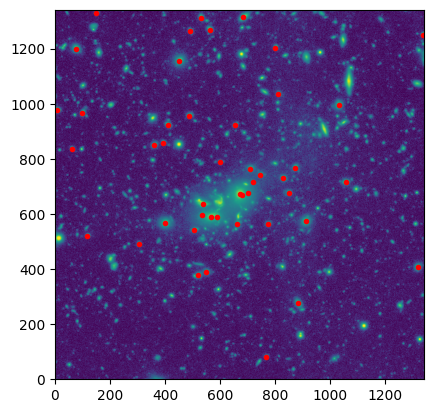

In [12]:
import astropy
# Plot positions of red cluster members
idx = 0

cutout = cutouts[str(idx)]['HDU0']['DATA']
plt.imshow(stretch(cutout), origin='lower')

def get_member_locs(idx: int, merged: astropy.table.Table, cutout_shape: tuple) -> tuple:
    # Get cluster location
    cluster_ra = merged[merged['ID'] == idx]['RA_cl'][0]
    cluster_dec = merged[merged['ID'] == idx]['Dec_cl'][0]
    centre_px = (cutout_shape[0] // 2, cutout_shape[1] // 2)

    # Get the cluster members
    c_members = merged[merged['ID'] == idx]
    ras = c_members['RA']
    decs = c_members['Dec']
    
    # Get offsets in degrees and convert to pixels
    ra_offsets = ras - cluster_ra
    dec_offsets = decs - cluster_dec
    x_offsets = ra_offsets * 3600 / 0.168
    y_offsets = dec_offsets * 3600 / 0.168

    # Get pixel locations
    centre = (cutout_shape[1] // 2, cutout_shape[0] // 2)
    x_locs_all = centre[0] - x_offsets # ra decreases from left to right
    y_locs_all = centre[1] + y_offsets
    x_locs = x_locs_all[(x_locs_all >= 0) & (x_locs_all < cutout.shape[1]) & (y_locs_all >= 0) & (y_locs_all < cutout.shape[0])]
    y_locs = y_locs_all[(x_locs_all >= 0) & (x_locs_all < cutout.shape[1]) & (y_locs_all >= 0) & (y_locs_all < cutout.shape[0])]
    
    return (x_locs, y_locs)

x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)

plt.scatter(x_locs, y_locs, color='red', marker='.')
plt.show()

/var/folders/f8/xskfv1jd2vndcb2pskfgrvch0000gp/T/ipykernel_1130/2684768698.py:78: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10(63095734448.0194 / counts) + 5 * np.log10(0.168) - 10 * np.log10(1+z)


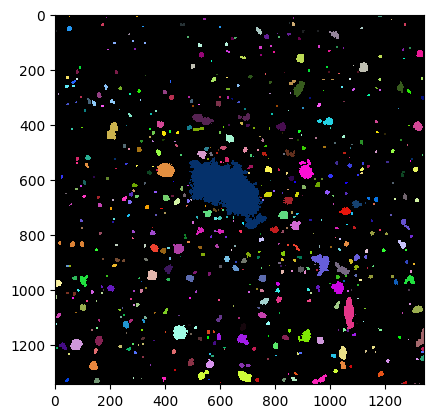

In [13]:
# Segment the image
cutout = np.array(cutouts[str(idx)]['HDU0']['DATA'])
bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
img = cutout - bkg
threshold = 26 + 10 * np.log10(1 + zs[idx])
sb_img = counts2sb(img, 0)
mask = sb_img > threshold

obj_mask = ~(mask + bad_mask + np.isnan(sb_img))

def segment(thresholded_img: np.ndarray) -> np.ndarray:
    # Erode and dilate the mask to get rid of the specks
    obj_mask_open = binary_opening(thresholded_img, np.ones((5,5)))
    binary_img = np.array(obj_mask_open, dtype=np.uint8)

    # Segment the image using connected components method
    _, labels = cv2.connectedComponents(binary_img, connectivity=8)
    return labels

labels = segment(obj_mask)

colours = np.random.rand(256, 3)
colours[0] = [0,0,0]
cmap = ListedColormap(colours)
plt.imshow(labels, cmap=cmap, interpolation='none')
plt.show()

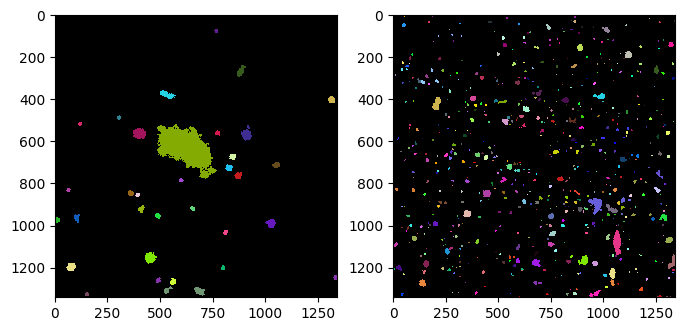

In [14]:
# Find the labels corresponding to the member galaxies
c_members = labels[y_locs.astype(int), x_locs.astype(int)]
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(labels * np.isin(labels, c_members), cmap=cmap, interpolation='none')
plt.subplot(122)
plt.imshow(labels * ~np.isin(labels, c_members), cmap=cmap, interpolation='none')
plt.show()

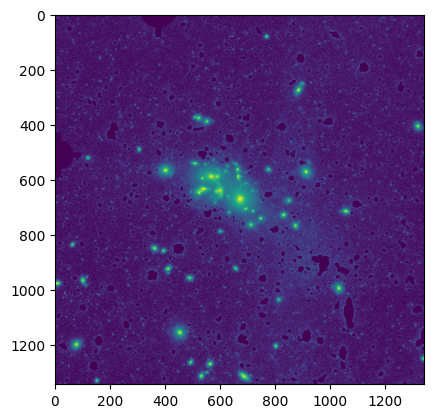

In [15]:
# Mask the image with the new mask
member_mask = np.isin(labels, c_members) | (labels == 0)

plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
plt.show()

0.6350996032829253


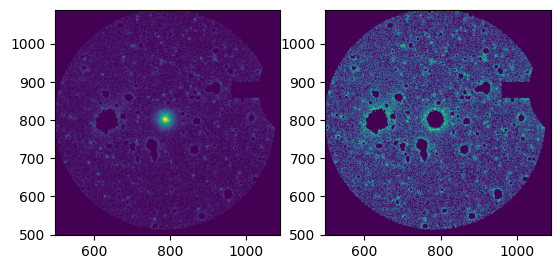

In [16]:
# Do the whole procedure and measure the ICL as well
idx = 80

# Prepare the cutout as normal
cutout = cutouts[str(idx)]['HDU0']['DATA']
bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
img = cutout - bkg
np.seterr(invalid='ignore', divide='ignore')
sb_img = counts2sb(img, 0)

# Flag the non member galaxies
seg_threshold = 26 + 10 * np.log10(1 + zs[idx])
mask = sb_img > seg_threshold
obj_mask = ~(mask + bad_mask + np.isnan(sb_img))
labels = segment(obj_mask)
x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
c_members = labels[y_locs.astype(int), x_locs.astype(int)]
member_mask = np.isin(labels, c_members) | (labels == 0) # also make sure to get the background in

# Check if cutout needs to be excluded
circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
inner_frac_masked = np.sum(bad_mask * circ_mask * member_mask) / np.sum(circ_mask)
mid = (bad_mask.shape[0] // 2, bad_mask.shape[1] // 2)

if inner_frac_masked > 0.2 or bad_mask[mid]:
    print('Too much masked')

# Calculate surface brightness limit (from Cristina's code (Roman+20))
_, _, stddev = sigma_clipped_stats(img, mask=bad_mask)
sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

# Mask out the values below surface brightness limit
sb_img[sb_img >= sb_lim] = np.nan

# Mask above the surface brightness threshold
threshold = 25 + 10 * np.log10(1 + zs[idx])
mask = sb_img > threshold

# Convert the SB image back to counts
counts_img = sb2counts(sb_img)

# Create the final masked image
masked_img = counts_img * ~bad_mask * member_mask * circ_mask

# Calculate ICL
print(np.nansum(masked_img * mask) / np.nansum(masked_img))

# Plot the image with and without mask
plt.subplot(121)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask))
lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
plt.xlim(*lims)
plt.ylim(*lims)
plt.subplot(122)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask * mask))
plt.xlim(*lims)
plt.ylim(*lims)
plt.show()

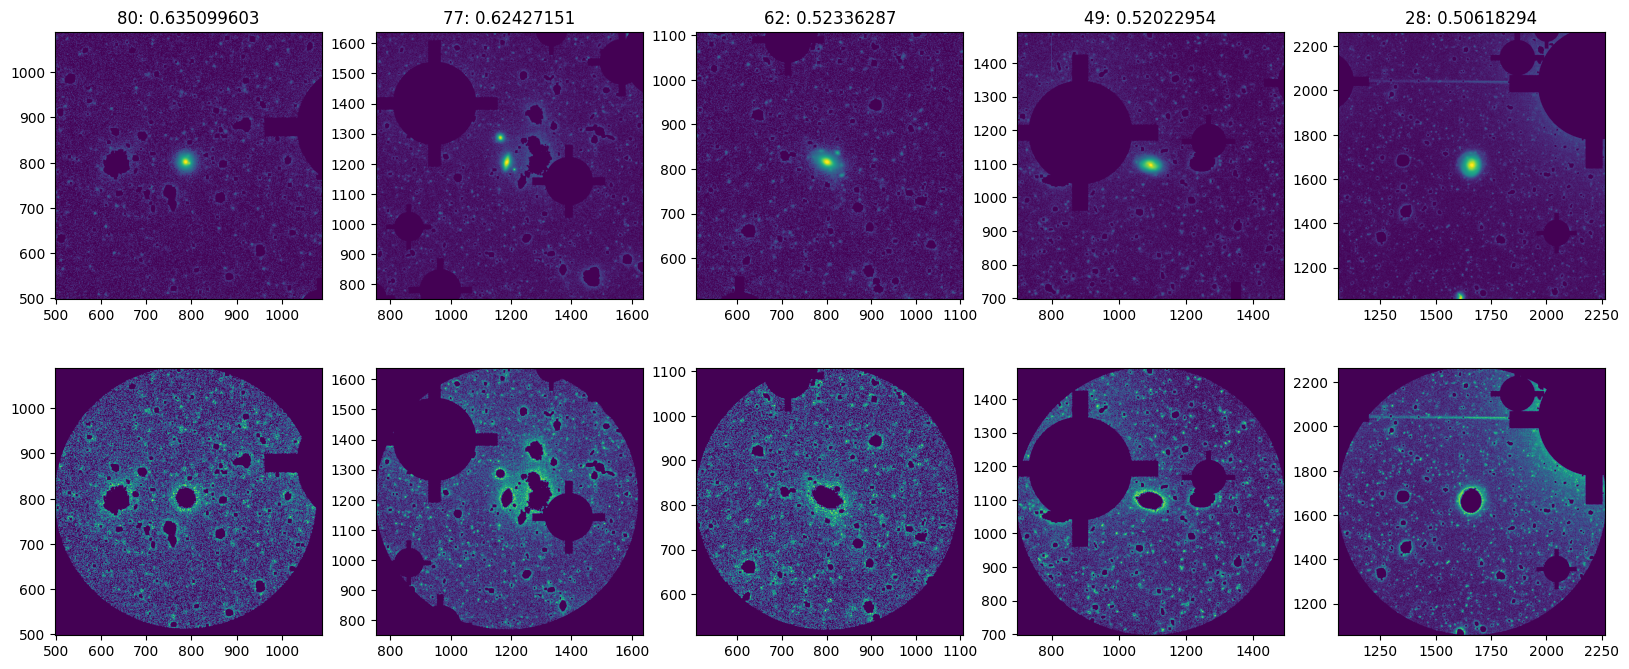

In [17]:
top_5 = [80, 77, 62, 49, 28]
top_5_fracs = [0.635099603, 0.62427151, 0.52336287, 0.52022954, 0.50618294]
bottom_5 = [9, 20, 33, 24, 54]
bottom_5_fracs = [0.04971414, 0.07405955, 0.07843977, 0.08815778, 0.08861491]

plt.figure(figsize=(20,8))
for i, idx in enumerate(top_5):
    plt.subplot(2, 5, i+1)
    cutout = cutouts[str(idx)]['HDU0']['DATA']
    bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

    circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
    
    bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
    img = cutout - bkg
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = counts2sb(img, 0)

    # Flag the non member galaxies
    seg_threshold = 26 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > seg_threshold
    obj_mask = ~(mask + bad_mask + np.isnan(sb_img))
    labels = segment(obj_mask)
    x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
    c_members = labels[y_locs.astype(int), x_locs.astype(int)]
    member_mask = np.isin(labels, c_members) | (labels == 0) # also make sure to get the background in

    plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.title(f'{idx}: {top_5_fracs[i]}')

    plt.subplot(2, 5, i+1+5)

    threshold = 25 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > threshold

    plt.imshow(stretch(cutout) * ~bad_mask * circ_mask * member_mask * mask)
    plt.xlim(*lims)
    plt.ylim(*lims)
plt.show()

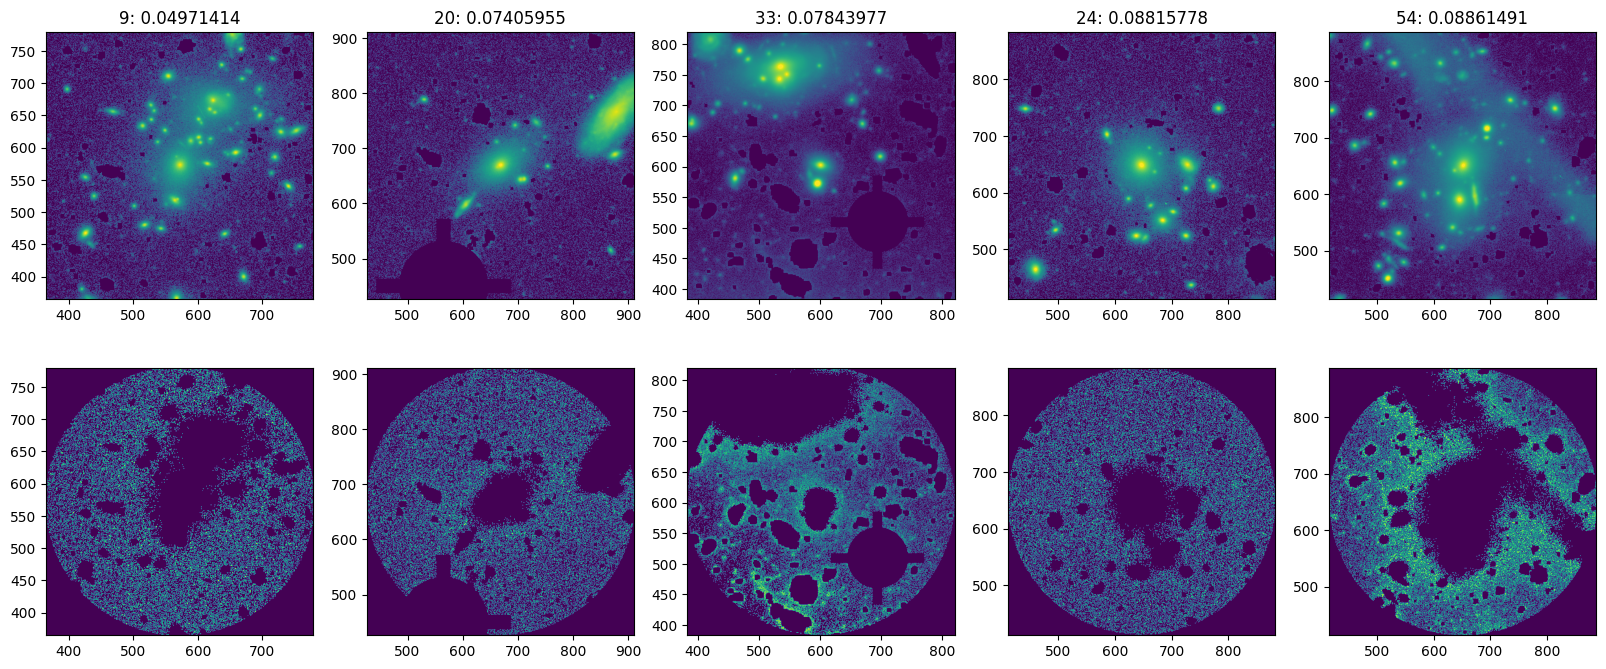

In [18]:
plt.figure(figsize=(20,8))
for i, idx in enumerate(bottom_5):
    plt.subplot(2, 5, i+1)
    cutout = cutouts[str(idx)]['HDU0']['DATA']
    bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

    circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
    
    bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
    img = cutout - bkg
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = counts2sb(img, 0)

    # Flag the non member galaxies
    seg_threshold = 26 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > seg_threshold
    obj_mask = ~(mask + bad_mask + np.isnan(sb_img))
    labels = segment(obj_mask)
    x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
    c_members = labels[y_locs.astype(int), x_locs.astype(int)]
    member_mask = np.isin(labels, c_members) | (labels == 0) # also make sure to get the background in

    plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.title(f'{idx}: {bottom_5_fracs[i]}')

    plt.subplot(2, 5, i+1+5)

    threshold = 25 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > threshold

    plt.imshow(stretch(cutout) * ~bad_mask * circ_mask * member_mask * mask)
    plt.xlim(*lims)
    plt.ylim(*lims)
plt.show()

There is still a lot of contributed light from the masked out galaxies - try dilating the masks?

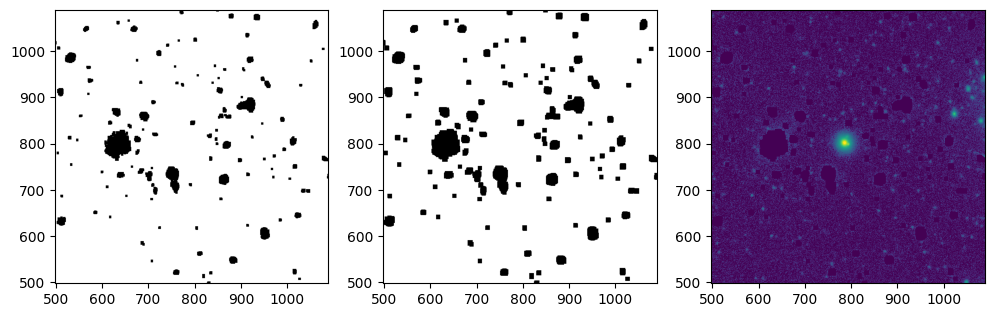

In [19]:
from skimage.morphology import binary_erosion

idx = 80

# Prepare the cutout as normal
cutout = cutouts[str(idx)]['HDU0']['DATA']
bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
img = cutout - bkg
np.seterr(invalid='ignore', divide='ignore')
sb_img = counts2sb(img, 0)

# Flag the non member galaxies
seg_threshold = 26 + 10 * np.log10(1 + zs[idx])
mask = sb_img > seg_threshold
obj_mask = ~(mask + bad_mask + np.isnan(sb_img))
labels = segment(obj_mask)
x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
c_members = labels[y_locs.astype(int), x_locs.astype(int)]
member_mask = np.isin(labels, c_members) | (labels == 0) # also make sure to get the background in

circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(member_mask, cmap='gray')
plt.xlim(*lims)
plt.ylim(*lims)
eroded_mask = binary_erosion(member_mask, footprint=np.ones((5,5)))
plt.subplot(132)
plt.imshow(eroded_mask, cmap='gray')
plt.xlim(*lims)
plt.ylim(*lims)
plt.subplot(133)
plt.imshow(stretch(cutout) * eroded_mask)
plt.xlim(*lims)
plt.ylim(*lims)
plt.show()

Want the larger masks to be dilated by a lot and the small masks to be dilated only a little.

## Try hot+cold masking method

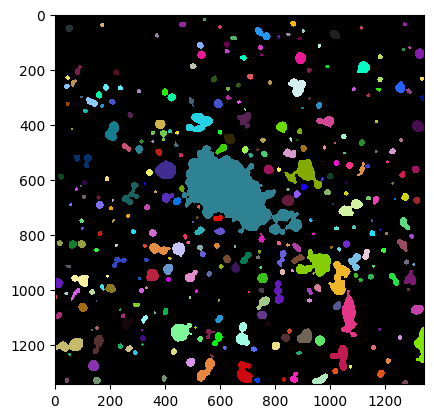

In [49]:
# Cold mask
from astropy.convolution import Gaussian2DKernel, convolve
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources

idx = 0

cutout = cutouts[str(idx)]['HDU0']['DATA']
bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)
bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)

def create_cold_labels(cutout, bad_mask, background):
    # First apply the bright star mask
    mask_input = np.array(cutout)
    mask_input[bad_mask] = np.nan

    # Smooth the image to help detect extended bright sources
    kernel = Gaussian2DKernel(5)
    kernel.normalize()
    convolved = convolve(mask_input, kernel)
    
    # Detect threshold
    threshold = detect_threshold(mask_input, nsigma=1.1, background=background, mask=bad_mask)

    # Detect sources
    segm = detect_sources(convolved, threshold=threshold, npixels=40)

    return segm.data

cold_labels = create_cold_labels(cutout, bad_mask, bkg)

# Show the masking result
plt.imshow(cold_labels, cmap=cmap, interpolation='none')
plt.show()

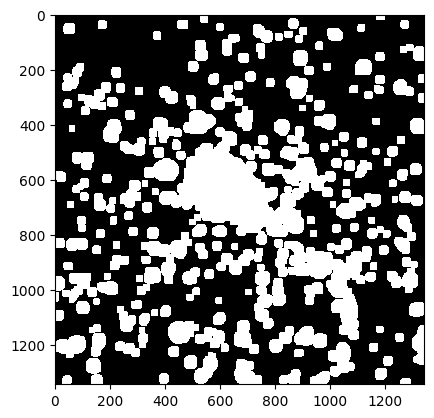

In [50]:
def enlarge_mask(labels, sigma=1):
    # Make the mask larger by convolving
    kernel = Gaussian2DKernel(sigma)
    mask = convolve(labels, kernel).astype(bool)

    return mask

cold_mask = enlarge_mask(cold_labels, sigma=2)

plt.imshow(cold_mask, cmap='gray', interpolation='none')
plt.show()

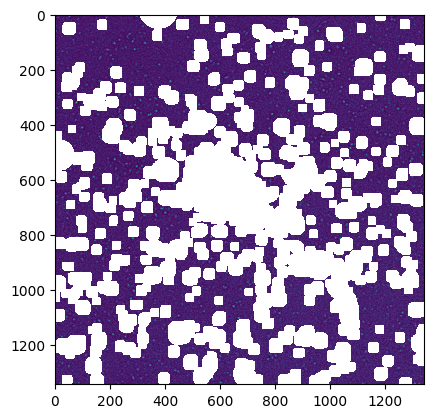

In [51]:
# Make the hot mask 
# Unsharp mask the image
kernel = Gaussian2DKernel(5)
conv_img = convolve(np.array(cutout), kernel)
unsharp = np.array(cutout) - conv_img

# Mask with the cold mask and bright star mask
unsharp[cold_mask] = np.nan
unsharp[bad_mask] = np.nan

plt.imshow(stretch(unsharp))
plt.show()

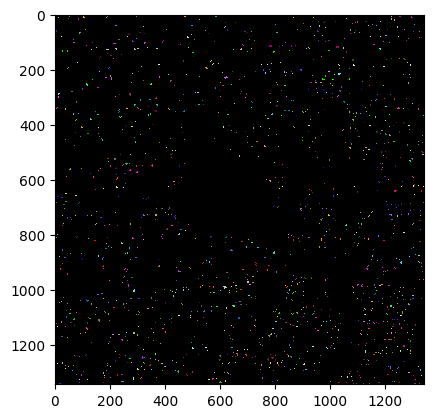

In [52]:
def create_hot_labels(unsharp, bad_mask, background):
    # Detect threshold
    threshold = detect_threshold(unsharp, nsigma=1.2, background=background, mask=bad_mask)
    
    # Detect sources
    segm = detect_sources(unsharp, threshold, npixels=7, mask=bad_mask)

    return segm.data

# Detect and deblend sources
hot_mask_bkg = background_estimate(unsharp, mask=(bad_mask.copy()), z=zs[idx], cosmo=cosmo)

hot_labels = create_hot_labels(unsharp, (bad_mask+cold_mask), hot_mask_bkg)

plt.imshow(hot_labels, cmap=cmap, interpolation='none')
plt.show()

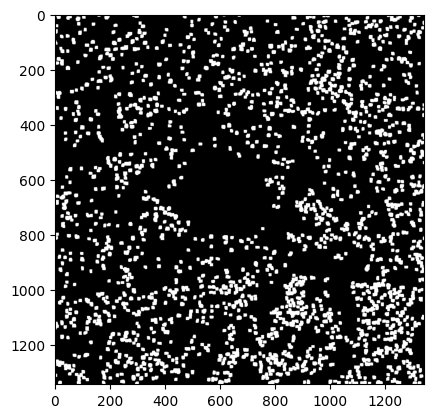

In [53]:
hot_mask = enlarge_mask(hot_labels, 1)

plt.imshow(hot_mask, cmap='gray')
plt.show()

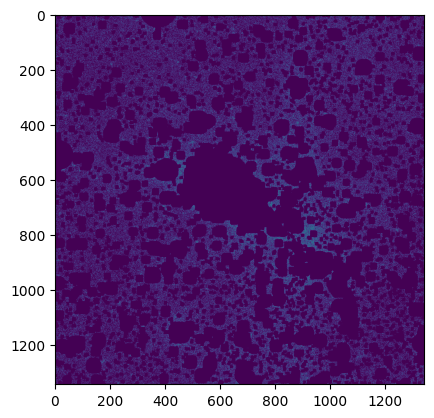

In [54]:
plt.imshow(stretch(cutout) * ~cold_mask * ~hot_mask * ~bad_mask)
plt.show()

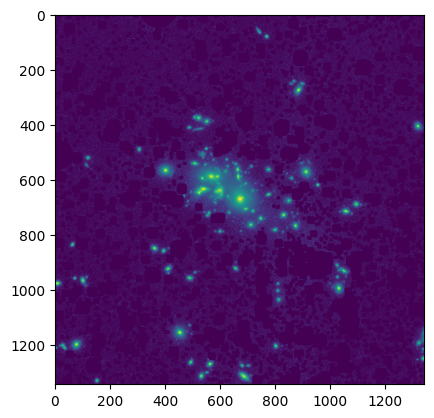

In [55]:
# Now mark the cluster members in the cold mask
x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
c_members = cold_labels[y_locs.astype(int), x_locs.astype(int)]
member_mask = np.isin(cold_labels, c_members) | (cold_labels == 0) # also make sure to get the background in

non_member_mask = ~member_mask

# Expand the non member mask again
non_member_mask = enlarge_mask(non_member_mask, sigma=2)

# Add in the hot mask
non_member_mask = non_member_mask + hot_mask
member_mask = ~non_member_mask

# Show the final mask
plt.imshow(stretch(cutout) * member_mask * ~bad_mask)
plt.show()

1534.6885252919712 19973.09428308486
0.07683779506271561


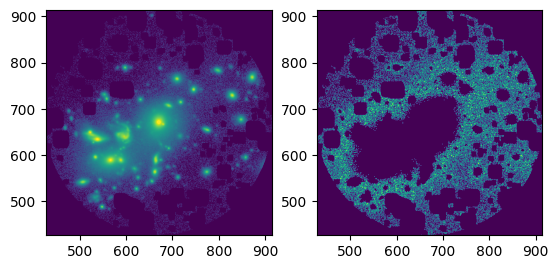

In [57]:
# Measure the ICL 
cutout = cutouts[str(idx)]['HDU0']['DATA']
bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
img = cutout - bkg
np.seterr(invalid='ignore', divide='ignore')
sb_img = counts2sb(img, 0)

# Check if cutout needs to be excluded
circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
inner_frac_masked = np.sum(bad_mask * circ_mask * member_mask) / np.sum(circ_mask)
mid = (bad_mask.shape[0] // 2, bad_mask.shape[1] // 2)

if inner_frac_masked > 0.2 or bad_mask[mid]:
    print('Too much masked')

# Calculate surface brightness limit (from Cristina's code (Roman+20))
_, _, stddev = sigma_clipped_stats(img, mask=bad_mask)
sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

# Mask out the values below surface brightness limit
sb_img[sb_img >= sb_lim] = np.nan

# Mask above the surface brightness threshold
threshold = 25 + 10 * np.log10(1 + zs[idx])
mask = sb_img > threshold

# Convert the SB image back to counts
counts_img = sb2counts(sb_img)

# Create the final masked image
masked_img = counts_img * ~bad_mask * member_mask * circ_mask
print(np.nansum(masked_img * mask), np.nansum(masked_img))
# Calculate ICL
print(np.nansum(masked_img * mask) / np.nansum(masked_img))

# Plot the image with and without mask
plt.subplot(121)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask))
lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
plt.xlim(*lims)
plt.ylim(*lims)
plt.subplot(122)
plt.imshow(stretch(img * ~bad_mask * member_mask * circ_mask * mask))
plt.xlim(*lims)
plt.ylim(*lims)
plt.show()

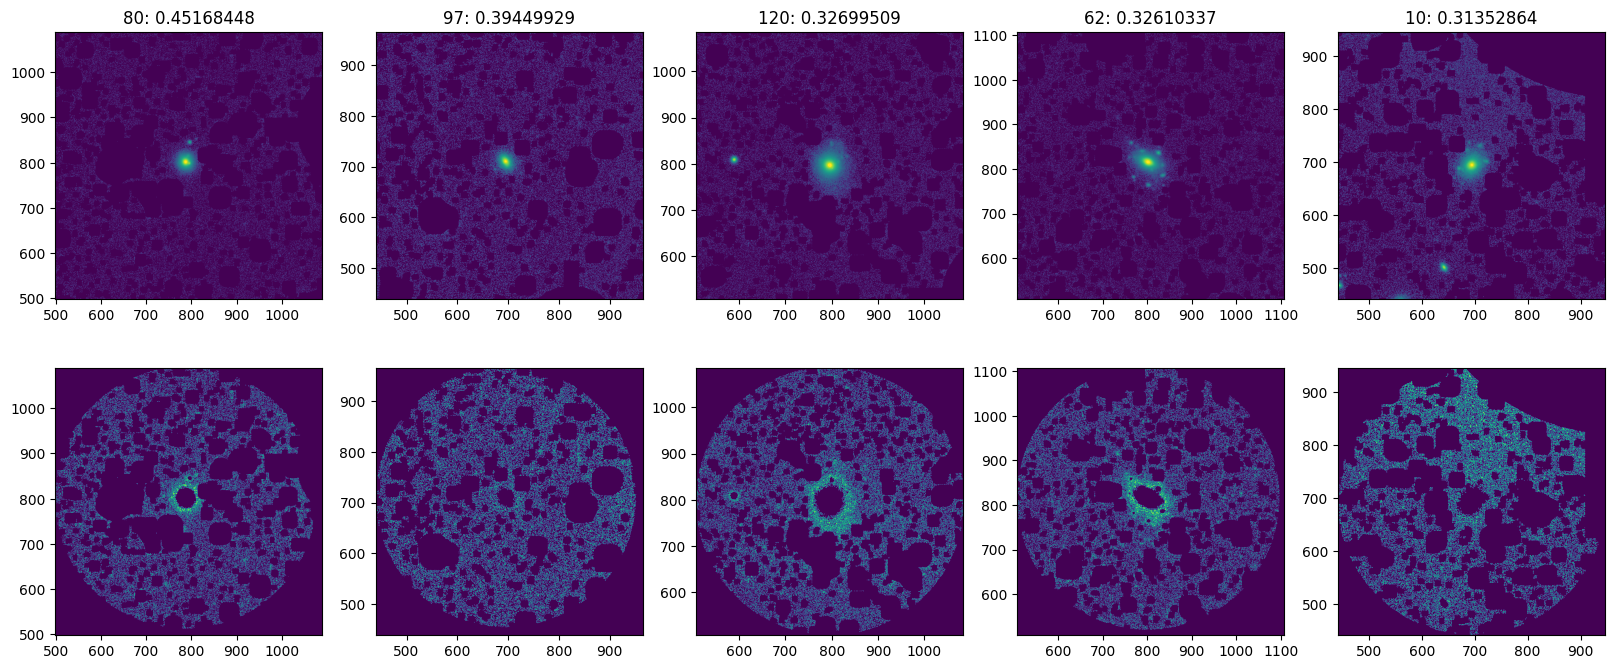

In [28]:
# Precalculated top and bottom fractions
top_5 = [80, 97, 120, 62, 10]
top_5_fracs = [0.45168448, 0.39449929, 0.32699509, 0.32610337, 0.31352864]
bottom_5 = [9, 4, 20, 33, 24]
bottom_5_fracs = [0.03791903, 0.03948924, 0.05079555, 0.05119633, 0.05489578]

import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter('ignore', category=AstropyWarning)

plt.figure(figsize=(20,8))
for i, idx in enumerate(top_5):
    plt.subplot(2, 5, i+1)
    cutout = cutouts[str(idx)]['HDU0']['DATA']
    bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

    circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
    
    bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
    img = cutout - bkg
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = counts2sb(img, 0)

    # First apply the bright star mask
    mask_input = np.array(cutout)
    mask_input[bad_mask] = np.nan

    # Smooth the image to help with detecting sources
    kernel = Gaussian2DKernel(5)
    kernel.normalize()
    convolved = convolve(mask_input, kernel)

    # Cold mask
    threshold = detect_threshold(mask_input, nsigma=1.1, background=bkg, mask=bad_mask)
    segm = detect_sources(convolved, threshold=threshold, npixels=40)
    cold_labels = segm.data
    kernel = Gaussian2DKernel(2)
    cold_mask = convolve(cold_labels, kernel).astype(bool) 
    
    # Make the hot mask 
    kernel = Gaussian2DKernel(5)
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img
    unsharp[cold_mask] = np.nan
    unsharp[bad_mask] = np.nan
    hot_mask_bkg = background_estimate(unsharp, mask=(bad_mask.copy()), z=zs[idx], cosmo=cosmo)
    threshold = detect_threshold(unsharp, nsigma=1.2, background=hot_mask_bkg, mask=(bad_mask+cold_mask))
    segm = detect_sources(unsharp, threshold, npixels=7, mask=(bad_mask+cold_mask))
    kernel = Gaussian2DKernel(1)
    hot_mask = convolve(segm.data, kernel).astype(bool)

    # Now mark the cluster members in the cold mask
    x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
    c_members = cold_labels[y_locs.astype(int), x_locs.astype(int)]
    member_mask = np.isin(cold_labels, c_members) | (cold_labels == 0) # also make sure to get the background in

    non_member_mask = ~member_mask

    # Expand the non member mask again
    kernel = Gaussian2DKernel(2)
    non_member_mask = convolve(non_member_mask, kernel).astype(bool)

    # Add in the hot mask
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask

    plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.title(f'{idx}: {top_5_fracs[i]}')

    plt.subplot(2, 5, i+1+5)

    threshold = 25 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > threshold

    plt.imshow(stretch(cutout) * ~bad_mask * circ_mask * member_mask * mask)
    plt.xlim(*lims)
    plt.ylim(*lims)
plt.show()

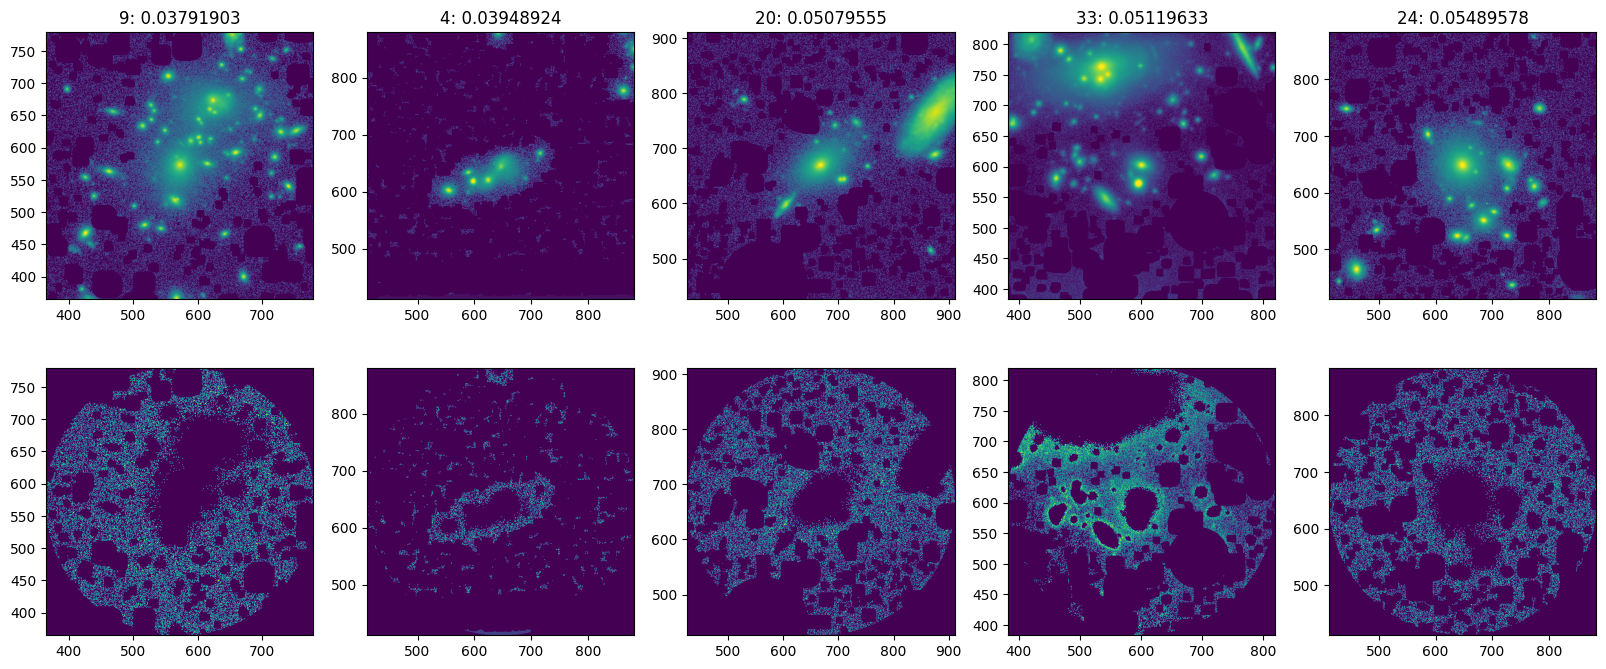

In [29]:
plt.figure(figsize=(20,8))
for i, idx in enumerate(bottom_5):
    plt.subplot(2, 5, i+1)
    cutout = cutouts[str(idx)]['HDU0']['DATA']
    bad_mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

    circ_mask = create_circular_mask(zs[idx], cutout, cosmo, radius_kpc=200)
    
    bkg = background_estimate(cutout, mask=bad_mask, z=zs[idx], cosmo=cosmo)
    img = cutout - bkg
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = counts2sb(img, 0)

    # First apply the bright star mask
    mask_input = np.array(cutout)
    mask_input[bad_mask] = np.nan

    # Smooth the image to help with detecting sources
    kernel = Gaussian2DKernel(5)
    kernel.normalize()
    convolved = convolve(mask_input, kernel)

    # Cold mask
    threshold = detect_threshold(mask_input, nsigma=1.1, background=bkg, mask=bad_mask)
    segm = detect_sources(convolved, threshold=threshold, npixels=40)
    cold_labels = segm.data
    kernel = Gaussian2DKernel(2)
    cold_mask = convolve(cold_labels, kernel).astype(bool) 
    
    # Make the hot mask 
    kernel = Gaussian2DKernel(5)
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img
    unsharp[cold_mask] = np.nan
    unsharp[bad_mask] = np.nan
    hot_mask_bkg = background_estimate(unsharp, mask=(bad_mask.copy()), z=zs[idx], cosmo=cosmo)
    threshold = detect_threshold(unsharp, nsigma=1.2, background=hot_mask_bkg, mask=(bad_mask+cold_mask))
    segm = detect_sources(unsharp, threshold, npixels=7, mask=(bad_mask+cold_mask))
    kernel = Gaussian2DKernel(1)
    hot_mask = convolve(segm.data, kernel).astype(bool)

    # Now mark the cluster members in the cold mask
    x_locs, y_locs = get_member_locs(idx, merged, cutout.shape)
    c_members = cold_labels[y_locs.astype(int), x_locs.astype(int)]
    member_mask = np.isin(cold_labels, c_members) | (cold_labels == 0) # also make sure to get the background in

    non_member_mask = ~member_mask

    # Expand the non member mask again
    kernel = Gaussian2DKernel(2)
    non_member_mask = convolve(non_member_mask, kernel).astype(bool)

    # Add in the hot mask
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask

    plt.imshow(stretch(cutout) * ~bad_mask * member_mask)
    lims = (np.min(np.nonzero(circ_mask)), np.max(np.nonzero(circ_mask)))
    plt.xlim(*lims)
    plt.ylim(*lims)
    plt.title(f'{idx}: {bottom_5_fracs[i]}')

    plt.subplot(2, 5, i+1+5)

    threshold = 25 + 10 * np.log10(1 + zs[idx])
    mask = sb_img > threshold

    plt.imshow(stretch(cutout) * ~bad_mask * circ_mask * member_mask * mask)
    plt.xlim(*lims)
    plt.ylim(*lims)
plt.show()